In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('drive/My Drive/BTL')
os.getcwd()

'/content/drive/My Drive/BTL'

In [4]:
#import các thư viện cần thiết 
import keras 
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, Flatten, Dropout, Dense, MaxPooling2D, Input
from tensorflow.keras import Sequential
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import csv

In [6]:
#đọc data
with open('A_Z Handwritten Data.csv', 'r') as csv_file:
    result = csv.reader(csv_file)
    rows = [] 
    labels = []
 
    # đọc từng dòng của file và thêm vào list rows, mỗi phần tử của list là một dòng
    for row in result:
        rows.append(np.array([int(i) for i in row[:][1:]]).reshape(28, 28))
        labels.append(row[:][0])

In [7]:
print(rows[80000])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  11  92
  176  84   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  10  98  65  11   0   0   0   0   0  17 120
  210  84   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 110 224 212  70   0   0   0   0   0  17 120
  223 113   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 122 228 246 109  12   0   0   0   0  17 120
  250 170   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  44 191 252 120  17   0   0   0   

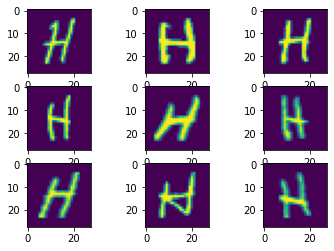

In [8]:
import cv2
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.imshow(rows[i+80000])

In [9]:
# đếm số số lương ảnh trong trong nhãn
from collections import Counter
count = Counter(labels) 
print(count['0'])


13870


In [10]:
# Số luong anh trong nhan sau khi dem
count_alpha = [13870,8668,23409,10134,11440,1163,5762,7218,1120,8493,5603,11586,12336,19010,57825,19341,5812,11566,48419,22495,29008,4182,10784,6272,10859,6076]

In [11]:
class_name = ['A','B','C','D','E','F','G','H','I','J','K','L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


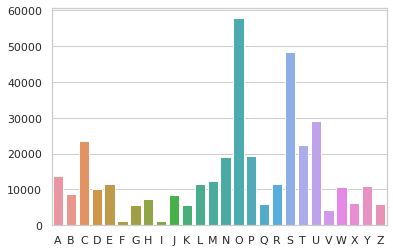

In [12]:
#do thi thong ke anh co trong moi nhan
import seaborn as sns
sns.set_theme(style="whitegrid")
X = class_name
Y = count_alpha 
ax = sns.barplot(X, Y)

In [13]:
#kích thước ảnh đầu vào model yêu cầu
input_shape = 28,28,1
#số lượng lần training 
epochs = 10
#số lượng ảnh đưa vào mỗi lần trong 1 epochs: 
batch_size = 32

In [14]:
#chia dữa liệu ra làm 3 tập: train, validation, test
#random_state sẽ giúp chia bộ dữ liệu thành những tâp con có tỉ lệ như nhau
x_train, x_val, y_train, y_val = train_test_split(rows, labels, test_size=0.2, random_state=42) 
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.2, random_state=42)

In [15]:
#hiện các x_train, y_train,... đang ở dạng list, để có thể reshape về đúng định dạng input, t cần chuyển list thành array
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)

In [16]:
#reshape lại ảnh về đúng định dạng model yêu cầu và /255 là normalize dữ liệu về khoảng 0-1 giúp quá trình training hội tụ tốt hơn
# shape[0] trả về số hàng của mảng 
# Dữ liệu input cho mô hình convolutional neural network là 1 tensor 4 chiều (N, W, H, D), trong bài này là ảnh xám nên W = H = 28, D = 1, N là số lượng ảnh cho mỗi lần training. 
# Do dữ liệu ảnh ở trên có kích thước là (N, 28, 28) tức là (N, W, H) nên rần reshape lại thành kích thước N 28 28 * 1 để giống kích thước mà keras yêu cầu.
x_train = x_train.reshape(x_train.shape[0], 28,28,1).astype('float32')/255
x_val = x_val.reshape(x_val.shape[0], 28,28,1).astype('float32')/255
x_test = x_test.reshape(x_test.shape[0], 28,28,1).astype('float32')/255

In [17]:
#one-hot-encoding labels
#One-hot encoding là một quá trình mà các biến phân loại (label) được chuyển đổi thành một mẫu có thể cung cấp cho các thuật toán
classes = 26 

y_train = np_utils.to_categorical(y_train, num_classes=classes)
y_val = np_utils.to_categorical(y_val, num_classes=classes)
y_test = np_utils.to_categorical(y_test, num_classes=classes)


In [19]:
#build models
model = Sequential() 
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape = input_shape))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu')) 
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten()) 
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(26, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                  

In [20]:
#callbacks: lưu lại các weights(trọng số) đã được học sau khi training models.
filepath = 'classify_chadapter.hdf5'
checkpoint = ModelCheckpoint(filepath,
                             monitor = 'val_acc',
                             verbose = 1,
                             save_best_only = True,
                             mode = 'max')

callbacks_list = [checkpoint]

In [21]:
#compile models: optimizer là một thuật toán gradient desent giúp tìm được minimine loss function(hàm mất mát, hàm sai số), metrics đánh giá models: ở đây là xác suất.
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#training models
His = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_val,y_val),callbacks=callbacks_list)

Epoch 1/10
9312/9312 [==============================] - 130s 13ms/step - loss: 0.4254 - accuracy: 0.8797 - val_loss: 0.0944 - val_accuracy: 0.9727
Epoch 2/10
9312/9312 [==============================] - 120s 13ms/step - loss: 0.1110 - accuracy: 0.9694 - val_loss: 0.0734 - val_accuracy: 0.9798
Epoch 3/10
9312/9312 [==============================] - 119s 13ms/step - loss: 0.0833 - accuracy: 0.9772 - val_loss: 0.0557 - val_accuracy: 0.9843
Epoch 4/10
9312/9312 [==============================] - 121s 13ms/step - loss: 0.0701 - accuracy: 0.9806 - val_loss: 0.0495 - val_accuracy: 0.9864
Epoch 5/10
9312/9312 [==============================] - 121s 13ms/step - loss: 0.0599 - accuracy: 0.9835 - val_loss: 0.0488 - val_accuracy: 0.9866
Epoch 6/10
9312/9312 [==============================] - 121s 13ms/step - loss: 0.0539 - accuracy: 0.9850 - val_loss: 0.0410 - val_accuracy: 0.9886
Epoch 7/10
9312/9312 [==============================] - 122s 13ms/step - loss: 0.0477 - accuracy: 0.9866 - val_loss: 0

In [22]:
# đọc và lưu models.
# model.save('huynq.hdf5')
read_model = load_model('huynq.hdf5')

In [23]:
#tính accuracy trên test set 
score = read_model.evaluate(x_test, y_test, verbose=1)
print('loss_score: ', score[0],'\n', 'accuracy_score: ', score[1])

466/466 [==============================] - 11s 5ms/step - loss: 0.0343 - accuracy: 0.9896
loss_score:  0.03425907716155052 
 accuracy_score:  0.9895966053009033


In [32]:
import cv2
img = cv2.imread('test7.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(28,28))
img = img.reshape(1,28,28,1)
PREDICT = read_model.predict(img)
print("giá trị dự đoán:  ", class_name[np.argmax(PREDICT)])

giá trị dự đoán:   S
